In [1]:
# if you need to install openptv-python, it's recommended to use conda

# Create conda environment with openptv-python
# conda create -n openptv_lineofsight python=3.10
# conda activate openptv_lineofsight
# pip install git+https://github.com/openptv/openptv-python.git
# conda install jupyter matplotlib numpy numba

In [2]:
# %pip install numba
# %pip install git+https://github.com/openptv/openptv-python.git

In [3]:
from openptv_python.calibration import Calibration
from openptv_python.parameters import ControlPar, VolumePar
from openptv_python.trafo import pixel_to_metric, dist_to_flat, metric_to_pixel
from openptv_python.multimed import ray_tracing, move_along_ray
from openptv_python.imgcoord import img_coord
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# openptv way to get the line in 3D from the point in the image space and 
# the calibration parameters


def epipolar_curve_in_3D(
    image_point: np.ndarray,
    origin_cam: Calibration,
    num_points: int,
    cparam: ControlPar,
    vparam: VolumePar,
) -> np.ndarray:
    """
    Get the points lying on the epipolar line from one camera to the other, on.

    the edges of the observed volume. Gives pixel coordinates.

    Assumes the same volume applies to all cameras.

    Arguments:
    ---------
    image_point - the 2D point on the image
        plane of the camera seeing the point. Distorted pixel coordinates.
    Calibration origin_cam - current position and other parameters of the
        camera seeing the point.
    int num_points - the number of points to generate along the line. Minimum
        is 2 for both endpoints.
    ControlParams cparam - an object holding general control parameters.
    VolumeParams vparam - an object holding observed volume size parameters.

    Returns
    -------
    line_points - (num_points,2) array with projection camera image coordinates
        of points lying on the ray stretching from the minimal Z coordinate of
        the observed volume to the maximal Z thereof, and connecting the camera
        with the image point on the origin camera.
    """

    line_points = np.empty((num_points, 3))

    # Move from distorted pixel coordinates to straight metric coordinates.
    x, y = pixel_to_metric(image_point[0], image_point[1], cparam)
    x, y = dist_to_flat(x, y, origin_cam, 0.00001)

    vertex, direct = ray_tracing(x, y, origin_cam, cparam.mm)

    for pt_ix, Z in enumerate(
        np.linspace(vparam.z_min_lay[0], vparam.z_max_lay[0], num_points)
    ):
        # x = line_points[pt_ix], 0)
        # y = <double *>np.PyArray_GETPTR2(line_points, pt_ix, 1)

        line_points[pt_ix, :] = move_along_ray(Z, vertex, direct)
        
        # x, y = img_coord(pos, project_cam, cparam.mm)
        # line_points[pt_ix, 0], line_points[pt_ix, 1] = metric_to_pixel(x, y, cparam)

    return line_points

In [5]:
!ls '/home/user/Downloads/rbc300'

cal					     parameters_MultiPlane_Run
calibration_images			     parametersPlane1
cal.zip					     parametersPlane2
detect_blobs_using_skimage_16bit_tiff.ipynb  parametersPlane3
img					     parametersPlane4
man_ori.dat				     parametersPlane5
parameters				     res
parametersBackup			     tmp.addpar
parametersMultiPlane


In [6]:
# Read the required stuff from the working folder
import pathlib, os
working_path = pathlib.Path('/home/user/Downloads/rbc300')


In [7]:
with open(os.path.join(working_path, 'cal', 'cam1.tif.ori')) as f:
    data = f.read()
    
print(data)
    

328.98208759 -28.87301302 945.67240814
0.17977266 0.20028117 -0.03212693

0.9795050 0.0314793 0.1989449
0.0039504 0.9845193 -0.1752317
-0.2013813 0.1724262 0.9642172

-0.1093 0.0828
41.0000

0.000000000000000 0.000000000000000 150.000000000000000



In [8]:
data = np.fromstring(data, dtype=float, sep=' ')

In [9]:
data

array([ 3.28982088e+02, -2.88730130e+01,  9.45672408e+02,  1.79772660e-01,
        2.00281170e-01, -3.21269300e-02,  9.79505000e-01,  3.14793000e-02,
        1.98944900e-01,  3.95040000e-03,  9.84519300e-01, -1.75231700e-01,
       -2.01381300e-01,  1.72426200e-01,  9.64217200e-01, -1.09300000e-01,
        8.28000000e-02,  4.10000000e+01,  0.00000000e+00,  0.00000000e+00,
        1.50000000e+02])

In [10]:
camera_1_calibration = Calibration().from_file(os.path.join(working_path,"cal","cam1.tif.ori"), None)
control_parameters = ControlPar().from_file(os.path.join(working_path,"parameters","ptv.par"))
volume_parameters = VolumePar().from_file(os.path.join(working_path,"parameters","criteria.par"))

No addpar file found. Using default values for radial distortion


In [11]:
camera_1_calibration.ext_par, control_parameters.num_cams, volume_parameters.z_min_lay, volume_parameters.z_max_lay

(rec.array((328.98208759, -28.87301302, 945.67240814, 0.17977266, 0.20028117, -0.03212693, [[ 0.97950497,  0.03147932,  0.19894489], [ 0.00395042,  0.9845193 , -0.17523169], [-0.20138126,  0.17242623,  0.96421719]]),
           dtype=[('x0', '<f8'), ('y0', '<f8'), ('z0', '<f8'), ('omega', '<f8'), ('phi', '<f8'), ('kappa', '<f8'), ('dm', '<f8', (3, 3))]),
 4,
 [-150.0, -150.0],
 [150.0, 150.0])

In [12]:
curve_3D = epipolar_curve_in_3D(
    image_point=[control_parameters.imx/2, control_parameters.imy/2],
    origin_cam = camera_1_calibration,
    num_points = 10,
    cparam = control_parameters,
    vparam = volume_parameters,
)

In [13]:
cam_position = camera_1_calibration.get_pos()

In [14]:
cam_position

array([328.98208759, -28.87301302, 945.67240814])

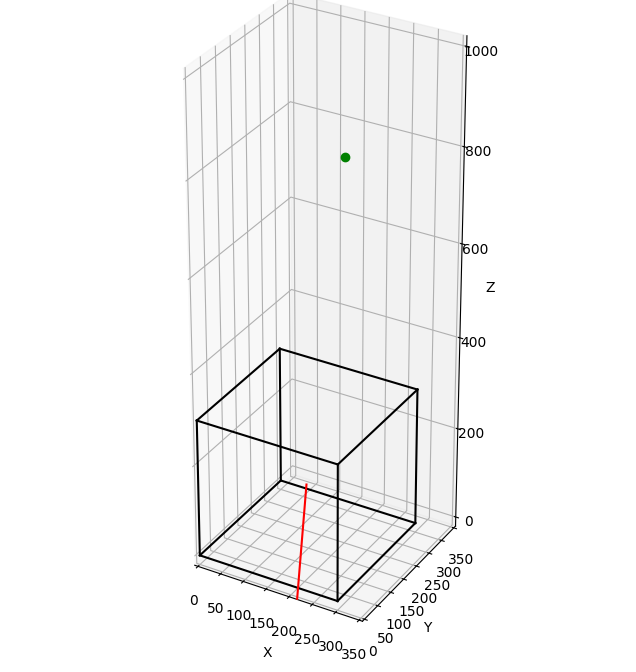

In [15]:
# plot line of sight
axis = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
axis.set_xlabel('X'), axis.set_ylabel('Y'), axis.set_zlabel('Z')
axis.set_xlim(0,350), axis.set_ylim(0,350), axis.set_zlim(0,1000)
axis.set_aspect('equal')

axis.plot([0,300],[0,0],[0,0],c='black'), axis.plot([0,0],[0,300],[0,0],c='black'), axis.plot([0,0],[0,0],[0,300],c='black')
axis.plot([300,300],[0,300],[0,0],c='black'), axis.plot([300,300],[0,0],[0,300],c='black'), axis.plot([0,300],[300,300],[0,0],c='black')
axis.plot([0,0],[300,300],[0,300],c='black'), axis.plot([0,300],[0,0],[300,300],c='black'), axis.plot([0,0],[0,300],[300,300],c='black')
axis.plot([300,300],[300,300],[0,300],c='black'), axis.plot([300,300],[0,300],[300,300],c='black'), axis.plot([0,300],[300,300],[300,300],c='black')
# for lof in LOF:
#     plt.plot( [lof[0,0],lof[0,0]+mu*lof[1,0]] , [lof[0,1],lof[0,1]+mu*lof[1,1]] , [lof[0,2],lof[0,2]+mu*lof[1,2]] ,'-',c='red')
plt.plot(cam_position[0],cam_position[1],cam_position[2],'o',c='green')
plt.plot(curve_3D[:,0],curve_3D[:,1],curve_3D[:,2],'-',c='red')

In [16]:
curve_3D

array([[ 122.413191  ,  153.35399705, -150.        ],
       [ 127.43369599,  148.9251037 , -116.66666667],
       [ 132.45420097,  144.49621035,  -83.33333333],
       [ 137.47470596,  140.067317  ,  -50.        ],
       [ 142.49521094,  135.63842365,  -16.66666667],
       [ 147.51571593,  131.2095303 ,   16.66666667],
       [ 152.53622091,  126.78063695,   50.        ],
       [ 157.5567259 ,  122.3517436 ,   83.33333333],
       [ 162.57723088,  117.92285025,  116.66666667],
       [ 167.59773587,  113.49395691,  150.        ]])

In [17]:
camera_2_calibration = Calibration().from_file(os.path.join(working_path,"cal","cam2.tif.ori"), None)
camera_2_calibration.ext_par

No addpar file found. Using default values for radial distortion


rec.array((-31.8057855, 296.73925838, 934.15425615, -0.19035329, -0.17516433, -0.02542993, [[ 0.98437954,  0.0250381 , -0.17426996], [ 0.00799432,  0.98245838,  0.18631057], [ 0.17587784, -0.18479348,  0.96691176]]),
          dtype=[('x0', '<f8'), ('y0', '<f8'), ('z0', '<f8'), ('omega', '<f8'), ('phi', '<f8'), ('kappa', '<f8'), ('dm', '<f8', (3, 3))])

In [18]:
control_parameters.mm

MultimediaPar(nlay=1, n1=1.0, n2=[1.46], d=[8.0], n3=1.33)

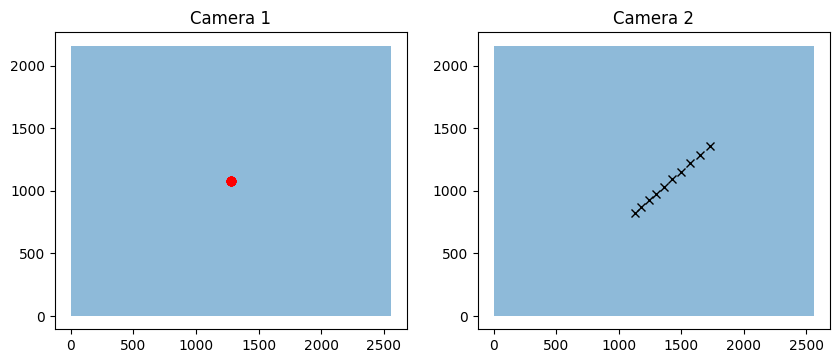

In [19]:
fig, ax = plt.subplots(1,2,figsize=(10,8))
from matplotlib.patches import Rectangle

ax[0].add_patch(Rectangle((0,0),control_parameters.imx, control_parameters.imy,alpha = 0.5))
ax[1].add_patch(Rectangle((0,0),control_parameters.imx, control_parameters.imy,alpha = 0.5))
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

for point in curve_3D:    
    x, y = img_coord(point, camera_1_calibration, control_parameters.mm)    
    x, y = metric_to_pixel(x, y, control_parameters)
    # print(x,y)
    
    ax[0].plot(x,y,'ro')
    
    
    x, y = img_coord(point, camera_2_calibration, control_parameters.mm)    
    x, y = metric_to_pixel(x, y, control_parameters)
    # print(x,y)
    ax[1].plot(x,y,'kx')    

ax[0].set_title('Camera 1')
ax[1].set_title('Camera 2')
plt.show()
    

In [20]:
# Now we try to create the line of sight using myptv 
from myptv.imaging_mod import camera_wrapper, img_system

# ThreeDModel = 'ExtendedZolof'     # <-- set either to 'Tsai' or to 'ExtendedZolof'
# ThreeDModel = 'Tsai'     # <-- set either to 'Tsai' or to 'ExtendedZolof'
cam_name = 'cam1'        # <-- set to one of: cam0, cam1, cam2, cam3
directory = '../MyPTV_LineOfSight/cam_Tsai'
cam = camera_wrapper(cam_name, directory)
cam.load()

print(cam)

Camera Wrapper instance; camera loaded:

Tsai model camera instace. cam1
 O: [ -17.3373435   282.78597128 1085.13981702]
 theta:[ 3.38610841  0.17512091 -0.00964929]
 f:7550.0


In [21]:
class LineOfSight(object):
    
    def __init__(self, cam):
        
        self.cam = cam
        
    
    def get_line(self, x, y):
        P, v = self.cam.get_epipolarline(x, y)
        return P, v
    
    
    def plot_line(self, x, y):
        P, v = self.get_line(x, y)
        
        
        axis = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
        axis.set_xlabel('X'), axis.set_ylabel('Y'), axis.set_zlabel('Z')
        axis.set_xlim(-50,350), axis.set_ylim(-50,350), axis.set_zlim(0,1200)

        axis.set_box_aspect([axis.get_xlim()[1] - axis.get_xlim()[0],
                             axis.get_ylim()[1] - axis.get_ylim()[0],
                             axis.get_zlim()[1] - axis.get_zlim()[0]])

        axis.plot([0,300],[0,0],[0,0],c='black'), axis.plot([0,0],[0,300],[0,0],c='black'), axis.plot([0,0],[0,0],[0,300],c='black')
        axis.plot([300,300],[0,300],[0,0],c='black'), axis.plot([300,300],[0,0],[0,300],c='black'), axis.plot([0,300],[300,300],[0,0],c='black')
        axis.plot([0,0],[300,300],[0,300],c='black'), axis.plot([0,300],[0,0],[300,300],c='black'), axis.plot([0,0],[0,300],[300,300],c='black')
        axis.plot([300,300],[300,300],[0,300],c='black'), axis.plot([300,300],[0,300],[300,300],c='black'), axis.plot([0,300],[300,300],[300,300],c='black')


        plt.plot(P[0],P[1],P[2],'o',c='green')
        
        curve_3D = np.array([P+10*v])
        for a_ in np.linspace(0, -P[2]/v[2], num=10):
            curve_3D = np.concatenate((curve_3D, np.array([P + a_*v])))
        
        plt.plot(curve_3D[:,0],curve_3D[:,1],curve_3D[:,2],'-',c='red')
        
        
        
        

LOS = LineOfSight(cam)

In [22]:
LOS.get_line(control_parameters.imx/2, control_parameters.imy/2)


(array([ -17.3373435 ,  282.78597128, 1085.13981702]),
 array([-0.13134661,  0.13683179,  0.98184781]))

In [23]:
cam_position = camera_1_calibration.get_pos()
curve_3D = epipolar_curve_in_3D(
    image_point=[control_parameters.imx/2, control_parameters.imy/2],
    origin_cam = camera_1_calibration,
    num_points = 10,
    cparam = control_parameters,
    vparam = volume_parameters,
)

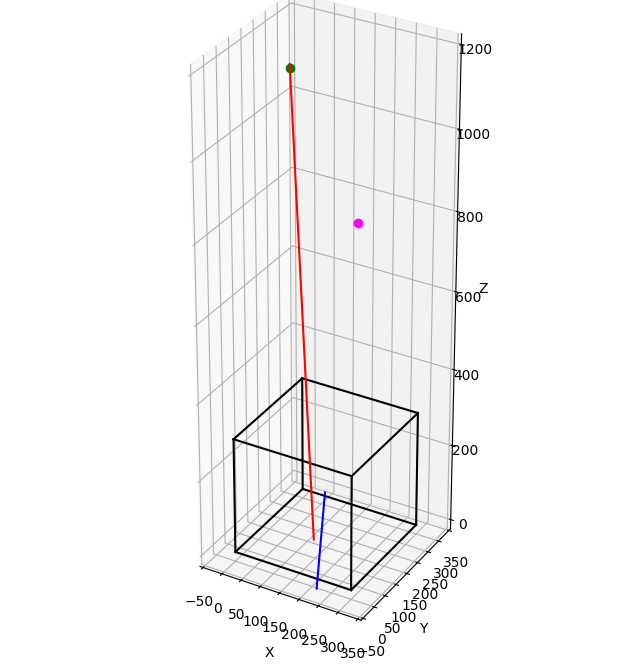

In [24]:

LOS.plot_line(control_parameters.imx/2, control_parameters.imy/2)

plt.plot(cam_position[0],cam_position[1],cam_position[2],'o',c='magenta')
plt.plot(curve_3D[:,0],curve_3D[:,1],curve_3D[:,2],'-',c='blue')
